In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from scipy import stats

In [8]:
df = pd.read_csv("Clean_Dataset.csv",index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [9]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [10]:
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


*Data Visualization*

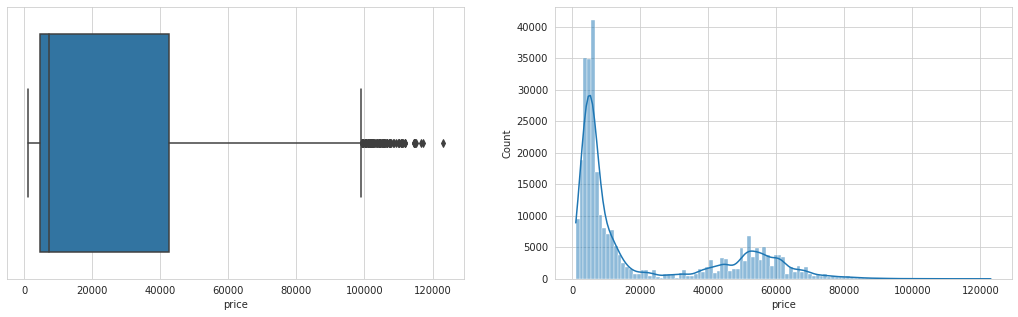

In [11]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

Text(0.5, 1.0, 'Airline prices based on companies for business tickets')

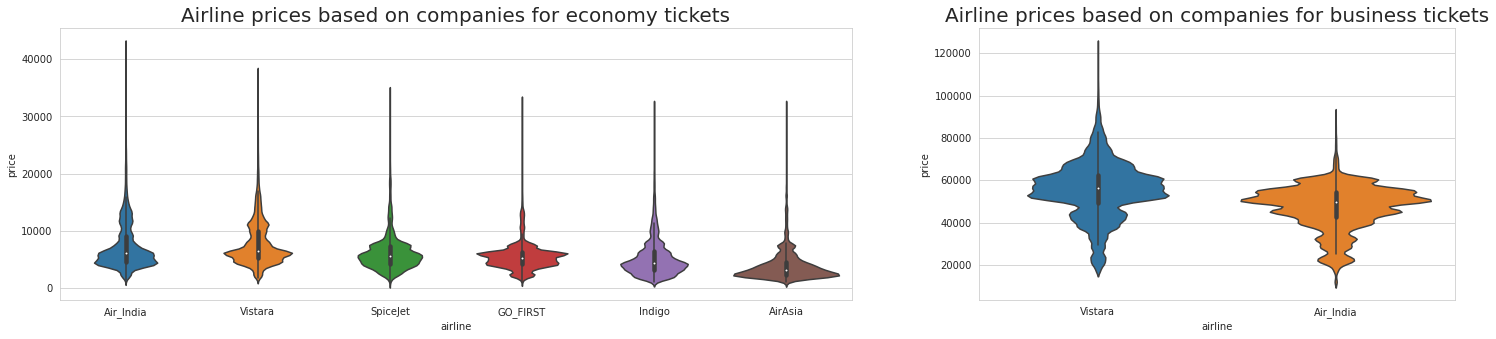

In [12]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), kind="boxen", ax=axs[0])
axs[0].set_title("Airline prices based on companies for economy tickets",fontsize=20)
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), kind="boxen", ax=axs[1])
axs[1].set_title("Airline prices based on companies for business tickets",fontsize=20)

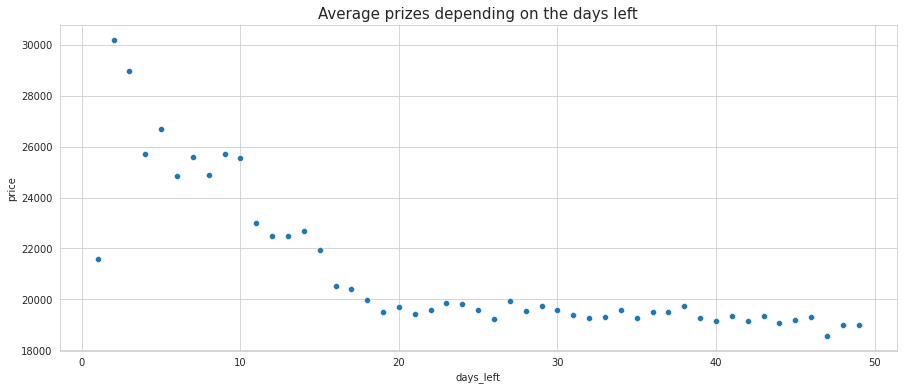

In [13]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=15)

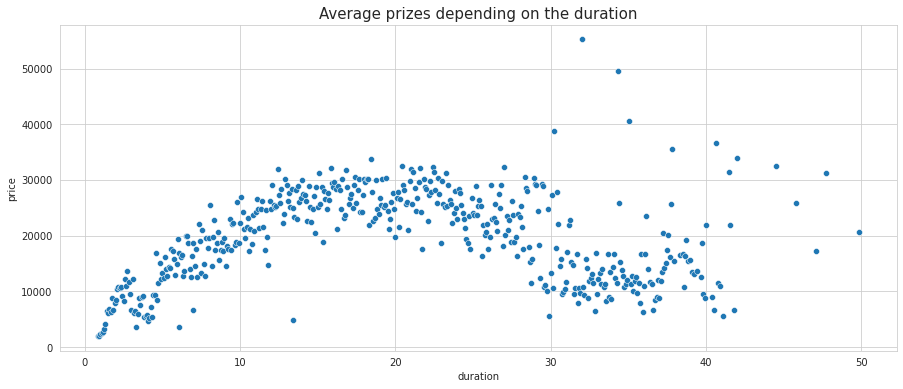

In [14]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)


*Data Preprocessing*

In [27]:
def preprocessing(df):
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)
    
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)
    
    return df

In [18]:
df = pd.read_csv("Clean_Dataset.csv",index_col=0)
# Preprocessing the data
df = preprocessing(df)
X = df.copy()
y = X.pop("price")
    
xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)

*Training Models*

In [20]:
models = {}

models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_neighbors=50)}
models["LinearRegression"]={"model":LinearRegression()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)}

In [21]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()
    
    return score_r2

In [22]:
def get_scores(models,xtrain,ytrain):
    for name,model in models.items():
        model["model"].fit(xtrain,ytrain)

        score_r2 = score_dataset(xtrain, ytrain, model=model["model"])
        score = {'model':"Linear regression", 'score_r2':score_r2}
        print("--- "+name+" ---")
        print("Score r2: {}".format(score_r2))
        print("\n")

In [23]:
get_scores(models,xtrain,ytrain)

--- KNeighborsRegressor ---
Score r2: 0.7091120580806901


--- LinearRegression ---
Score r2: 0.9095338142489373


[07:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- XGBRegressor ---
Score r2: 0.9821663952552744




*Applying XGB regressor on test data*

In [24]:
model = models["XGBRegressor"]["model"]
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)

[07:53:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


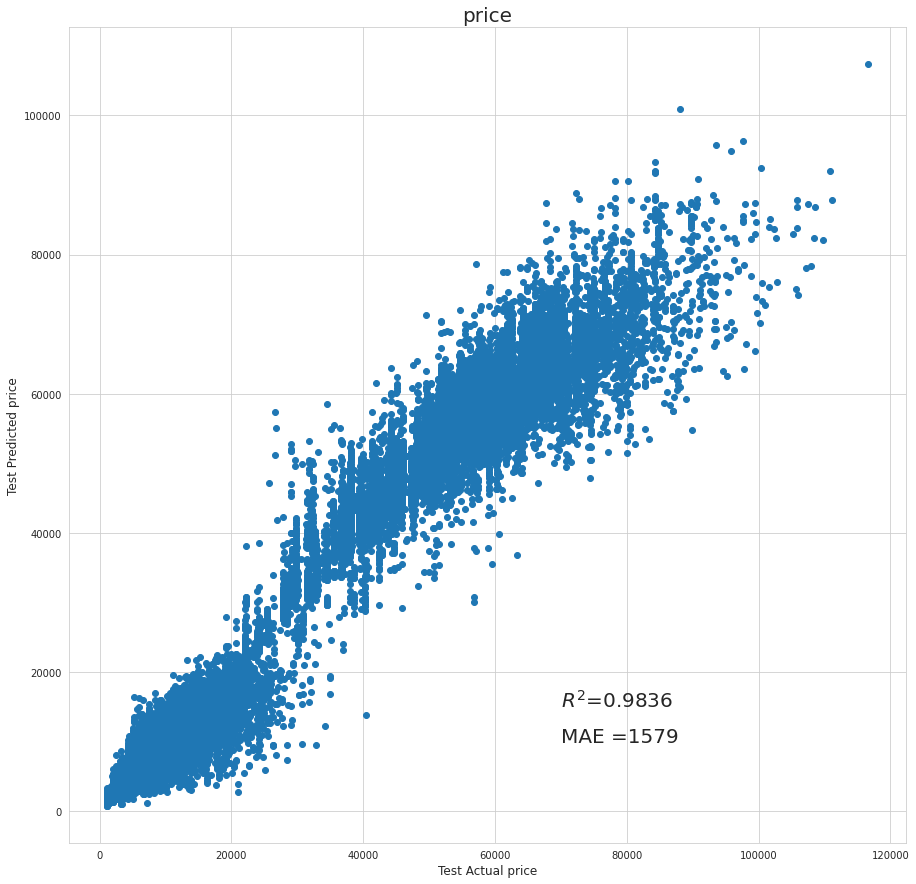

In [30]:
fig,ax = plt.subplots(figsize=(15,15))
ax.set_title("price",fontsize=20)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(ytest,ypred)

score_r2 = r2_score(ytest, ypred) 
score_mae = mean_absolute_error(ytest, ypred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=20)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=20)
plt.show()

*Best R2 score with XGB regressor = 0.9836*